In [2]:
import pandas as pd
import arff

# Load the .arff file
file_path = './data/EEG_Eye_State.arff'  # Update the path if necessary
with open(file_path, 'r') as f:
    arff_data = arff.load(f)

# Convert to pandas DataFrame
data = pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])

# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("First 5 Rows:")
print(data.head())

Dataset Shape: (14980, 15)
First 5 Rows:
       AF3       F7       F3      FC5       T7       P7       O1       O2  \
0  4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1  4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
2  4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
3  4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
4  4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   

        P8       T8      FC6       F4       F8      AF4 eyeDetection  
0  4222.05  4238.46  4211.28  4280.51  4635.90  4393.85            0  
1  4210.77  4226.67  4207.69  4279.49  4632.82  4384.10            0  
2  4207.69  4222.05  4206.67  4282.05  4628.72  4389.23            0  
3  4217.44  4235.38  4210.77  4287.69  4632.31  4396.41            0  
4  4210.77  4244.10  4212.82  4288.21  4632.82  4398.46            0  


In [3]:
# Check for missing values
print("Missing Values:\n", data.isnull().sum())

# Display basic statistics
print("\nBasic Statistics:\n", data.describe())

# Check the distribution of the target variable (Eye_State)
print("\nTarget Variable Distribution:")


Missing Values:
 AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

Basic Statistics:
                  AF3            F7            F3            FC5            T7  \
count   14980.000000  14980.000000  14980.000000   14980.000000  14980.000000   
mean     4321.917777   4009.767694   4264.022433    4164.946326   4341.741075   
std      2492.072174     45.941672     44.428052    5216.404632     34.738821   
min      1030.770000   2830.770000   1040.000000    2453.330000   2089.740000   
25%      4280.510000   3990.770000   4250.260000    4108.210000   4331.790000   
50%      4294.360000   4005.640000   4262.560000    4120.510000   4338.970000   
75%      4311.790000   4023.080000   4270.770000    4132.310000   4347.180000   
max    309231.000000   7804.6200

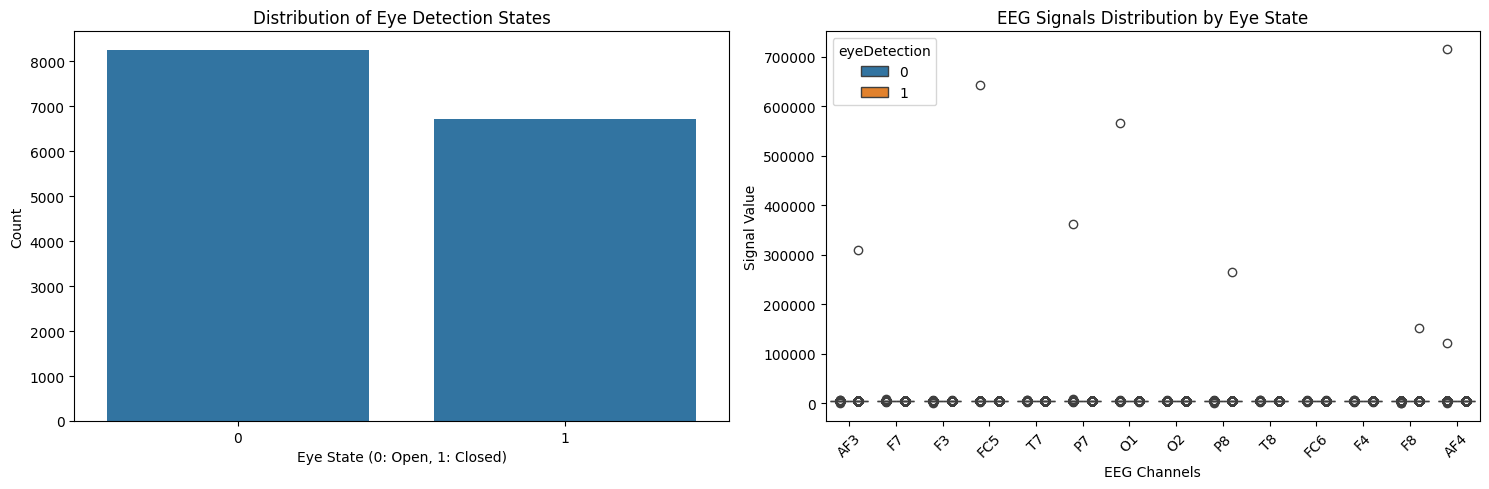

In [4]:
import seaborn as sns

# Import visualization libraries
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Distribution of eyeDetection
sns.countplot(data=data, x='eyeDetection', ax=ax1)
ax1.set_title('Distribution of Eye Detection States')
ax1.set_xlabel('Eye State (0: Open, 1: Closed)')
ax1.set_ylabel('Count')

# Plot 2: Box plot of EEG signals by eye state
data_melted = data.melt(id_vars=['eyeDetection'], 
                        value_vars=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 
                                  'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'])
sns.boxplot(data=data_melted, x='variable', y='value', hue='eyeDetection', ax=ax2)
ax2.set_title('EEG Signals Distribution by Eye State')
ax2.set_xlabel('EEG Channels')
ax2.set_ylabel('Signal Value')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [5]:
print(data.columns)

Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4', 'eyeDetection'],
      dtype='object')


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = data.drop(columns=['eyeDetection'])  # Features
y = data['eyeDetection']  # Target

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (11984, 14)
Testing Set Shape: (2996, 14)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Define the autoencoder
input_dim = X_train.shape[1]
autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(input_dim, activation='linear')  # Output layer
])

autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)

# Denoise the data
X_train_denoised = autoencoder.predict(X_train)
X_test_denoised = autoencoder.predict(X_test)

print("Denoised Data Shape:", X_train_denoised.shape)

Epoch 1/50


2025-04-19 18:24:20.010175: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7268 - val_loss: 0.0040
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3358 - val_loss: 0.1044
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8219 - val_loss: 0.0047
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5253 - val_loss: 0.0505
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3320 - val_loss: 0.0148
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3386 - val_loss: 0.0061
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5572 - val_loss: 0.0042
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3678 - val_loss: 0.0035
Epoch 9/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2897 - val_loss: 0.0041
Epoch 10/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3090 - val_loss: 0.0068
Epoch 11/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2036 - val_loss: 0.0024
Epoch 12/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.

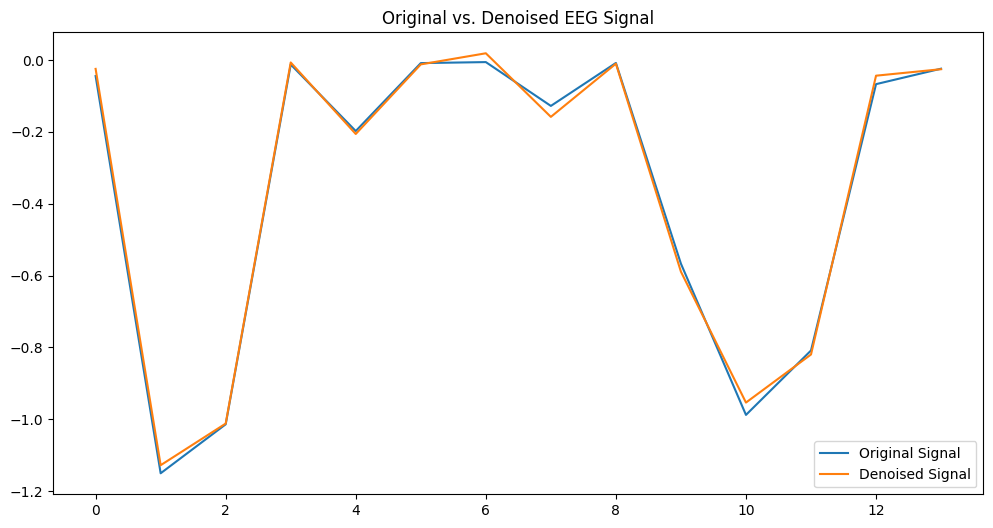

In [8]:
import matplotlib.pyplot as plt

# Plot original vs. denoised signals
plt.figure(figsize=(12, 6))
plt.plot(X_train[0], label='Original Signal')
plt.plot(X_train_denoised[0], label='Denoised Signal')
plt.legend()
plt.title('Original vs. Denoised EEG Signal')
plt.show()

In [9]:
import numpy as np

# Reshape the data for CNN (add a channel dimension)
X_train_cnn = X_train_denoised.reshape(X_train_denoised.shape[0], X_train_denoised.shape[1], 1)
X_test_cnn = X_test_denoised.reshape(X_test_denoised.shape[0], X_test_denoised.shape[1], 1)

print("CNN Input Shape (Training):", X_train_cnn.shape)
print("CNN Input Shape (Testing):", X_test_cnn.shape)

CNN Input Shape (Training): (11984, 14, 1)
CNN Input Shape (Testing): (2996, 14, 1)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

# Define the CNN model
cnn = Sequential([
    Input(shape=(X_train_cnn.shape[1], 1)),  # Input shape: (timesteps, features)
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 14, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,977 (74.13 KB)

 Trainable params: 18,977 (74.13 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Ensure X_train_cnn is numeric
X_train_cnn = X_train_cnn.astype('float32')
X_test_cnn = X_test_cnn.astype('float32')

# Ensure y_train and y_test are numeric
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [16]:
# Train the CNN
history = cnn.fit(X_train_cnn, y_train, epochs=200, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = cnn.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/200


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8646 - loss: 0.2916 - val_accuracy: 0.8198 - val_loss: 0.3868
Epoch 2/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8763 - loss: 0.2836 - val_accuracy: 0.8210 - val_loss: 0.3896
Epoch 3/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8718 - loss: 0.2774 - val_accuracy: 0.8290 - val_loss: 0.3833
Epoch 4/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8678 - loss: 0.2919 - val_accuracy: 0.8269 - val_loss: 0.3832
Epoch 5/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8711 - loss: 0.2876 - val_accuracy: 0.8277 - val_loss: 0.3888
Epoch 6/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8679 - loss: 0.2916 - val_accuracy: 0.8277 - val_loss: 0.3936
Epoch 7/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8739 - loss: 0.2836 - val_accuracy: 0.8164 - val_loss: 0.3962
Epoch 8/200
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8768 - loss: 0.2769 - val_accuracy: 0.8294

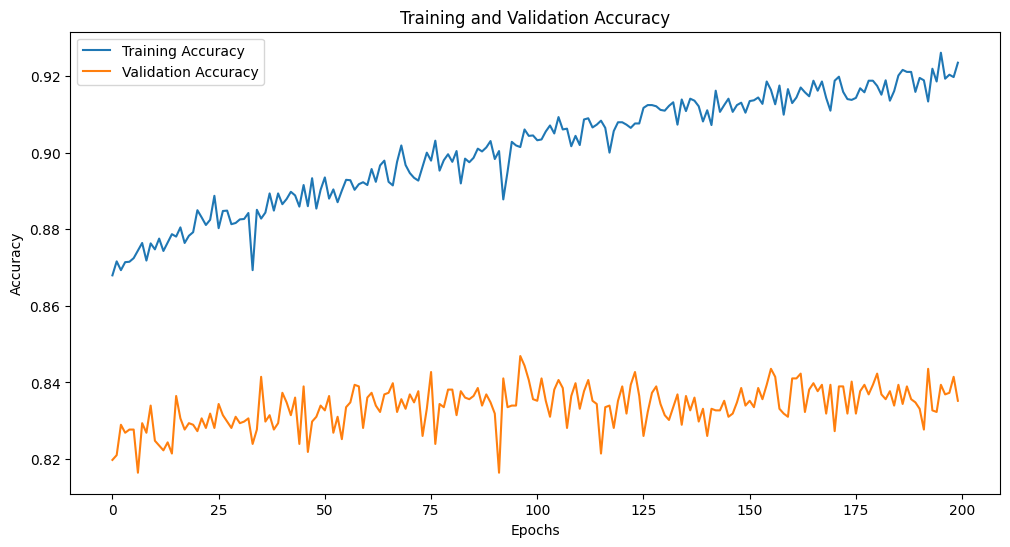

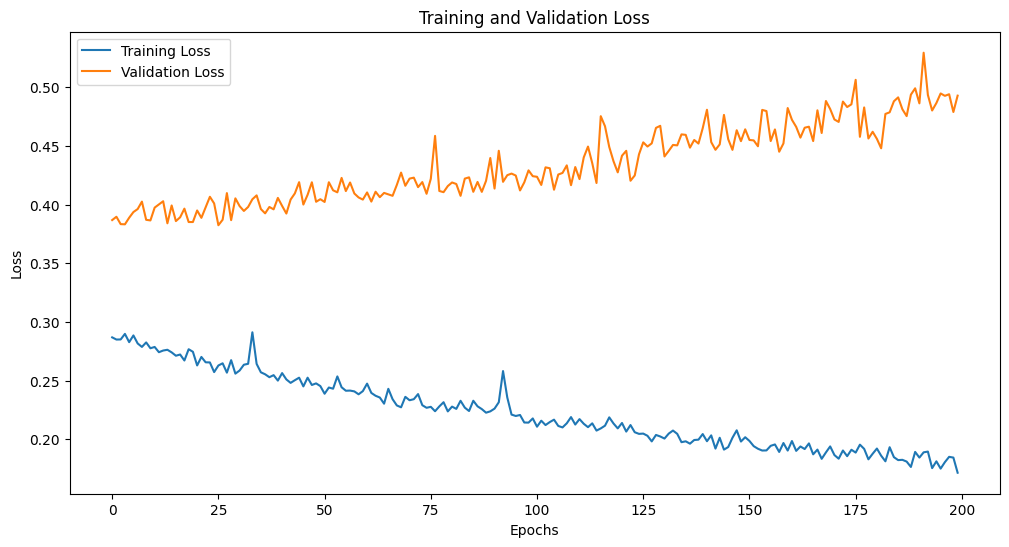

In [17]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Predict on the test set
y_pred = (cnn.predict(X_test_cnn) > 0.5).astype(int)

# Evaluate predictions
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[1353  233]
 [ 300 1110]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84      1586
         1.0       0.83      0.79      0.81      1410

    accuracy                           0.82      2996
   macro avg       0.82      0.82      0.82      2996
weighted avg       0.82      0.82      0.82      2996



94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


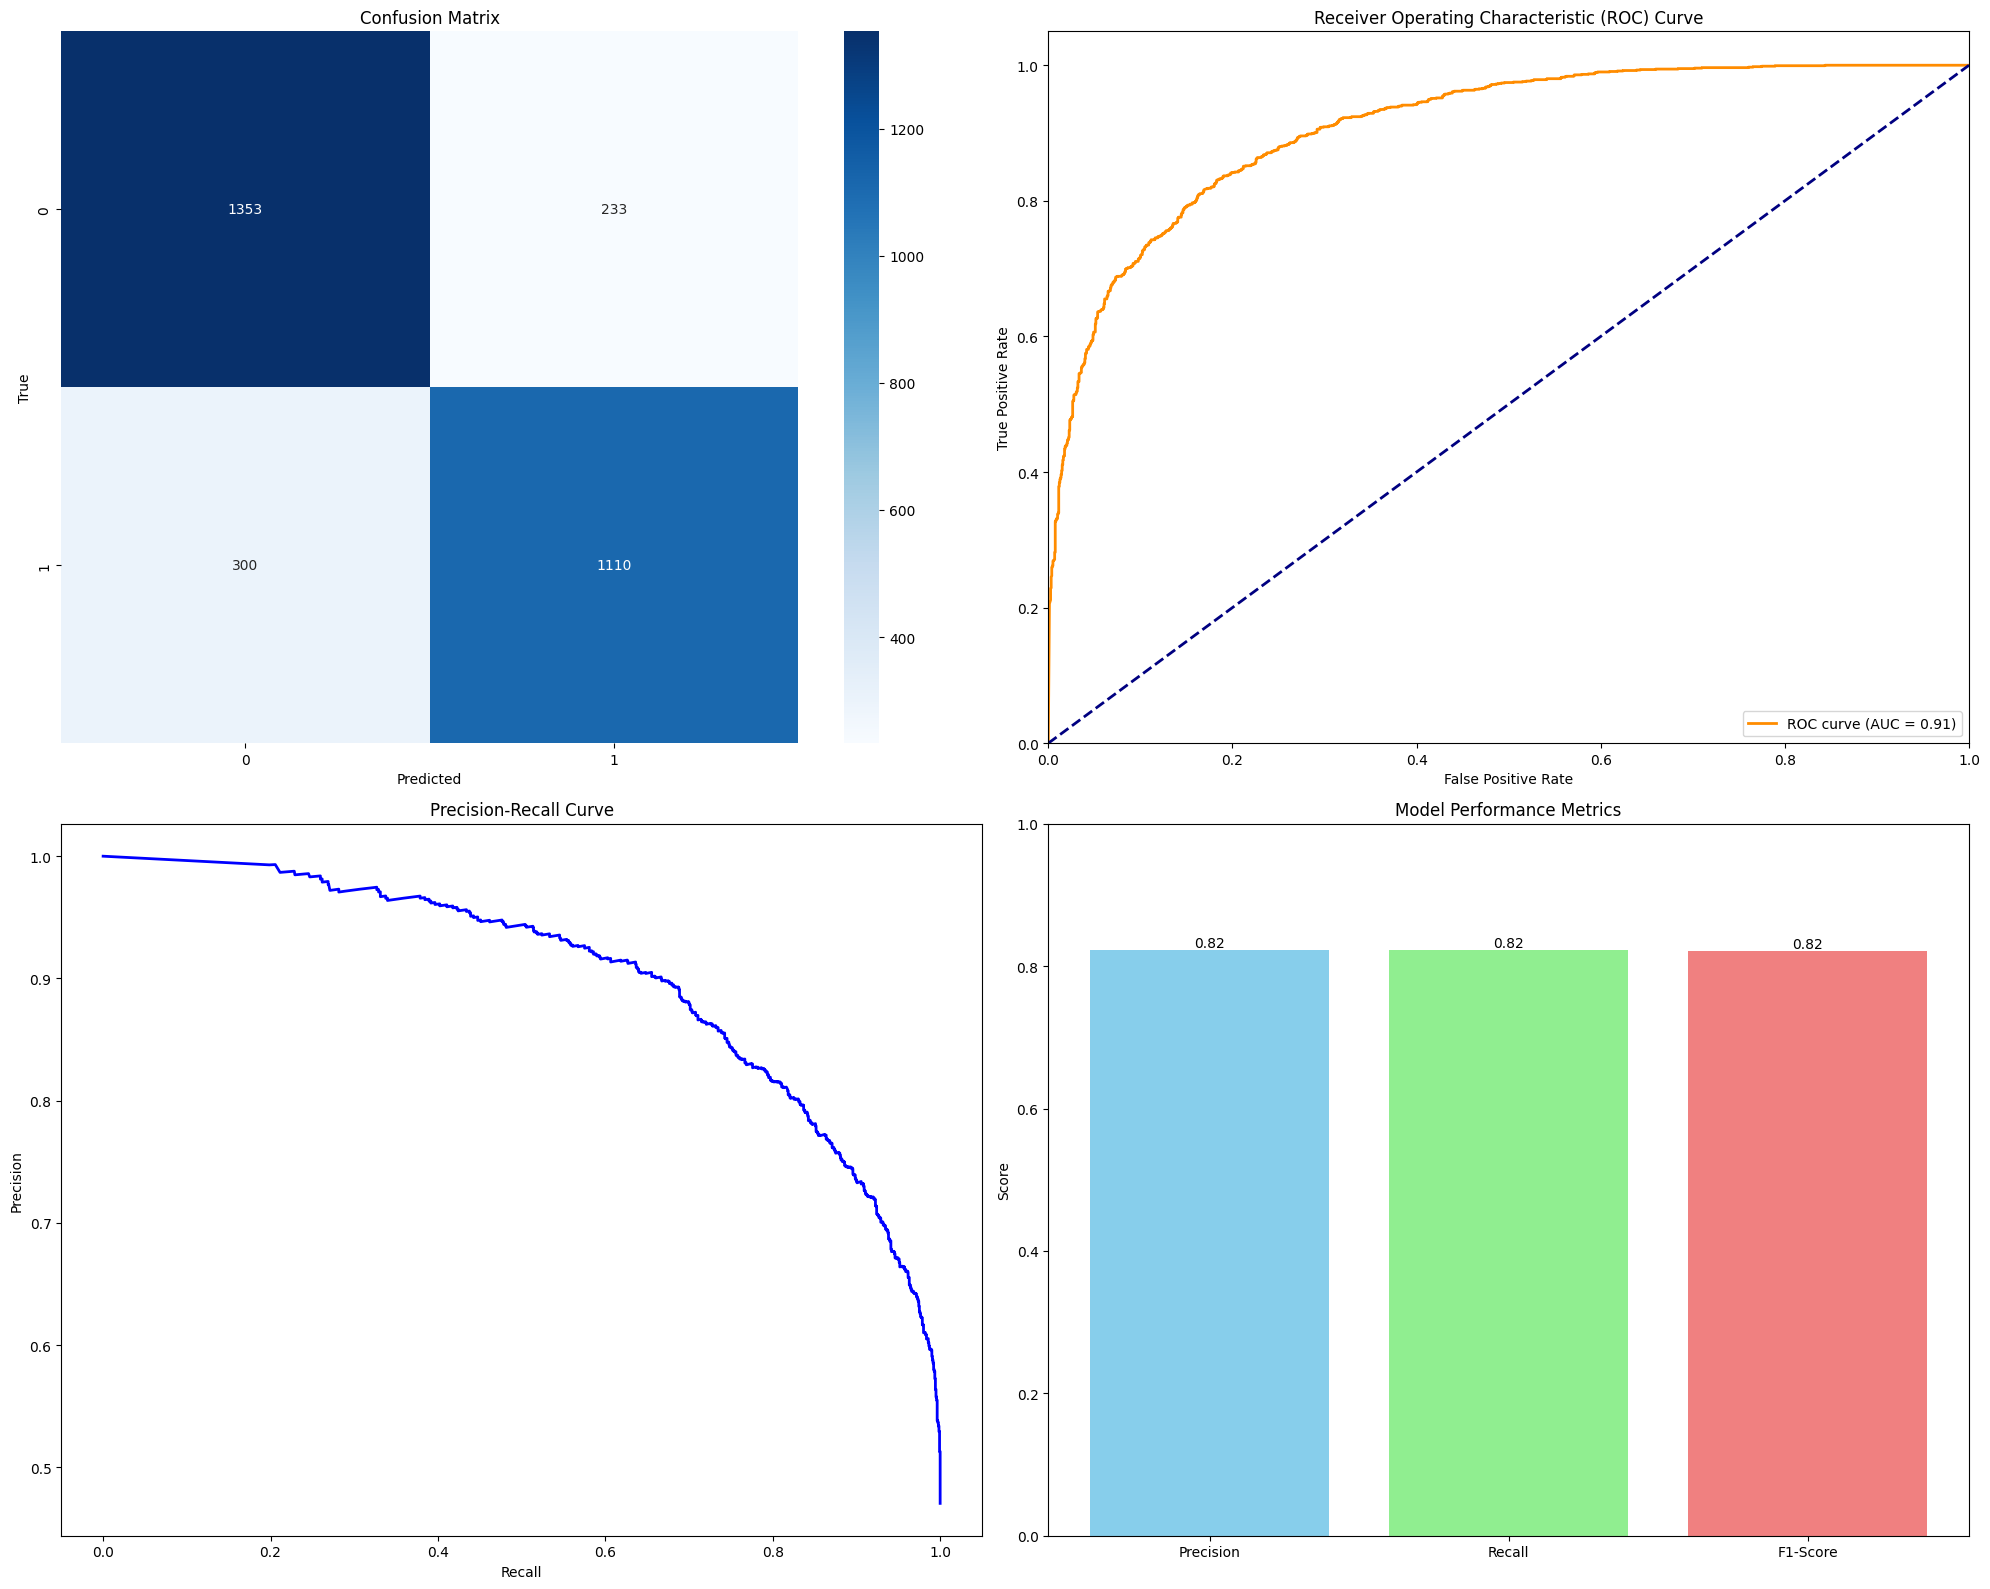


Model Performance Summary:
Accuracy: 0.822
Weighted Avg Precision: 0.822
Weighted Avg Recall: 0.822
Weighted Avg F1-Score: 0.822


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# Create a figure with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# 2. ROC Curve
y_pred_proba = cnn.predict(X_test_cnn)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
ax2.legend(loc="lower right")

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ax3.plot(recall, precision, color='blue', lw=2)
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curve')

# 4. Model Performance Metrics
metrics = classification_report(y_test, y_pred, output_dict=True)
class_metrics = metrics['weighted avg']
metric_names = ['Precision', 'Recall', 'F1-Score']
metric_values = [class_metrics['precision'], class_metrics['recall'], class_metrics['f1-score']]

bars = ax4.bar(metric_names, metric_values, color=['skyblue', 'lightgreen', 'lightcoral'])
ax4.set_ylim([0, 1])
ax4.set_title('Model Performance Metrics')
ax4.set_ylabel('Score')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nModel Performance Summary:")
print(f"Accuracy: {metrics['accuracy']:.3f}")
print(f"Weighted Avg Precision: {class_metrics['precision']:.3f}")
print(f"Weighted Avg Recall: {class_metrics['recall']:.3f}")
print(f"Weighted Avg F1-Score: {class_metrics['f1-score']:.3f}")